In [28]:
%load_ext autoreload
%autoreload 2

In [88]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

import sys
sys.path.append("/home/k/k202177/metcalc")
import metcalc
sys.path.append("../src")
import PCA_wrappers
import utils

In [89]:
era5 = xr.open_mfdataset("../data/era5/E5pl00_1M_*_130_ut.nc")

In [90]:
era5_tropics = xr.where((20 > era5.latitude.load()) & (era5.latitude.load() > -20), era5, np.nan).dropna("values")

In [91]:
era5_tropics

<xarray.Dataset>
Dimensions:        (values: 181760, time: 996, isobaricInhPa: 5)
Coordinates:
    step           timedelta64[ns] 00:00:00
    latitude       (values) float64 19.81 19.81 19.81 ... -19.81 -19.81 -19.81
    longitude      (values) float64 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * time           (time) datetime64[ns] 1940-01-01T12:00:00 ... 2022-12-01T1...
  * isobaricInhPa  (isobaricInhPa) float64 400.0 300.0 250.0 200.0 150.0
    valid_time     (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    t              (values, time, isobaricInhPa) float32 dask.array<chunksize=(181760, 12, 5), meta=np.ndarray>

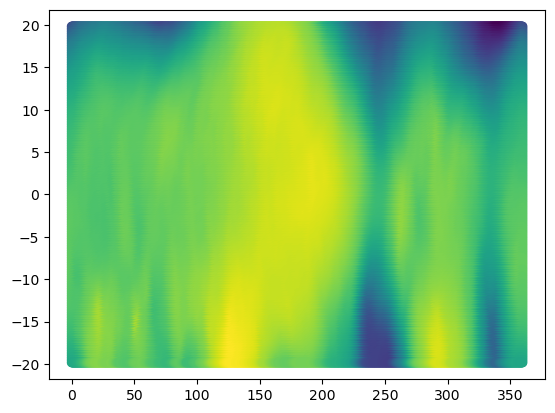

In [92]:
plt.scatter(era5_tropics.longitude,era5_tropics.latitude,c=era5_tropics.t.isel(time=0, isobaricInhPa=0))

In [93]:
level=300
var="t"

In [94]:
era5_ym = era5_tropics.groupby("time.year").mean().rename({"year" : "time"})
era5_norm, era5_mean, era5_std = utils.normalise(era5_tropics.sel(isobaricInhPa=level),["time"])
era5_ym_norm, era5_ym_mean, era5_ym_std = utils.normalise(era5_ym.sel(isobaricInhPa=level),["time"])


In [56]:
era5_PCA = PCA_wrappers.PCA_wrapper(era5_norm.t.transpose(), number_of_PCs = 5, coord_name="values" )

(5, 181760)


In [81]:
era5_ym_PCA = PCA_wrappers.PCA_wrapper(era5_ym_norm.t, number_of_PCs = 5, coord_name="values" )

In [87]:
!mkdir -p ../data/PCAs
era5_PCA.to_netcdf("../data/PCAs/era5_{var}_{level}_PCA.nc")
era5_ym_PCA.to_netcdf("../data/PCAs/era5_{var}_{level}_ym_PCA.nc")

# Plot

## PCA of Monthly Means

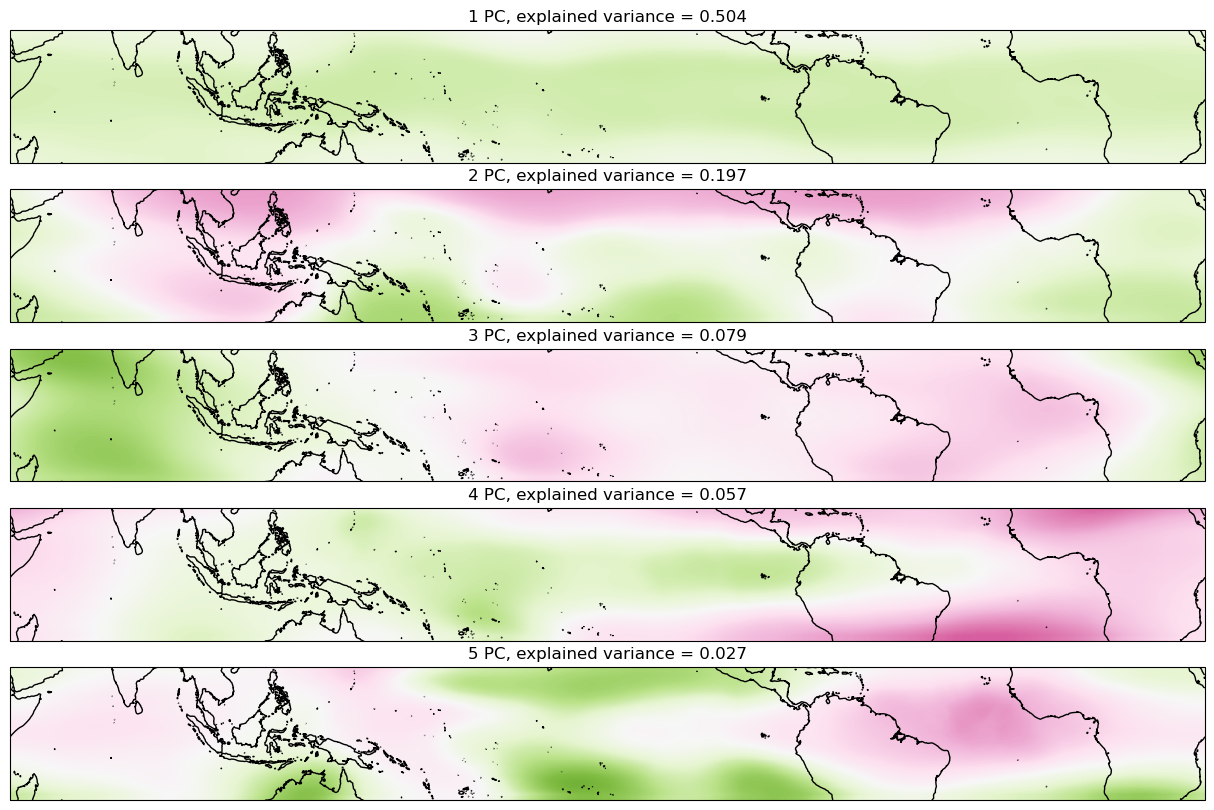

In [70]:
fig,xs = plt.subplots(len(era5_PCA.PCAs),1,figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

for i in range(len(era5_PCA.PCAs)) :
    ax=xs[i]
    ax.scatter(era5_tropics.longitude,era5_tropics.latitude,c=era5_PCA.components.sel(PCAs=i+1),cmap='PiYG', vmin=-0.01, vmax=0.01)
    metcalc.set_regional_cartopy(ax)
    ax.set_title(f"{i+1} PC, explained variance = {era5_PCA.sel(PCAs=i +1).explained_variance.values:.3f}")
    

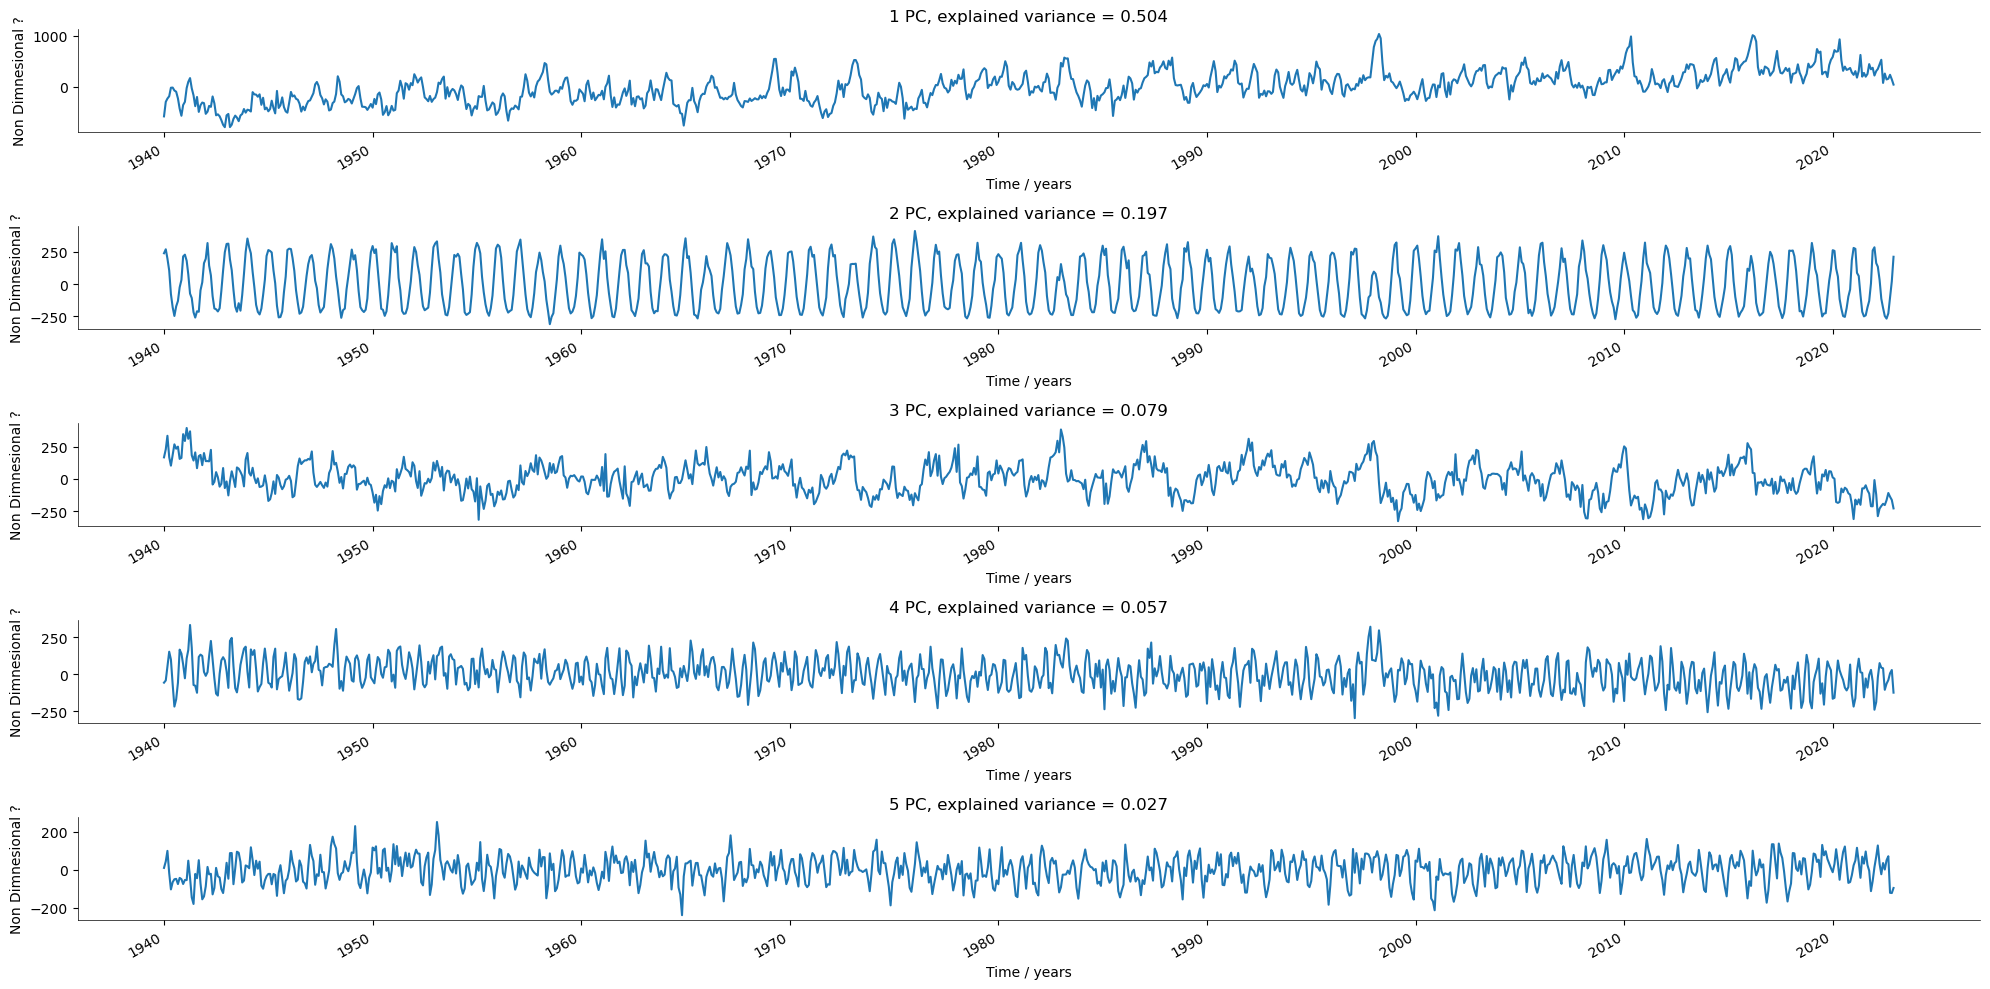

In [72]:
fig,xs = plt.subplots(len(era5_PCA.PCAs),1,figsize=(20,10))

for i in range(len(era5_PCA.PCAs)) :
    ax=xs[i]
    era5_PCA.sel(PCAs=i +1).time_series.plot(x="time",ax=ax)
    ax.set_xlabel("Time / years")
    ax.set_ylabel("Non Dimnesional ?")
    ax.set_title(f"{i+1} PC, explained variance = {era5_PCA.sel(PCAs=i +1).explained_variance.values:.3f}")
    metcalc.remove_axes(ax)
fig.tight_layout()
    

## PCA of yearly means

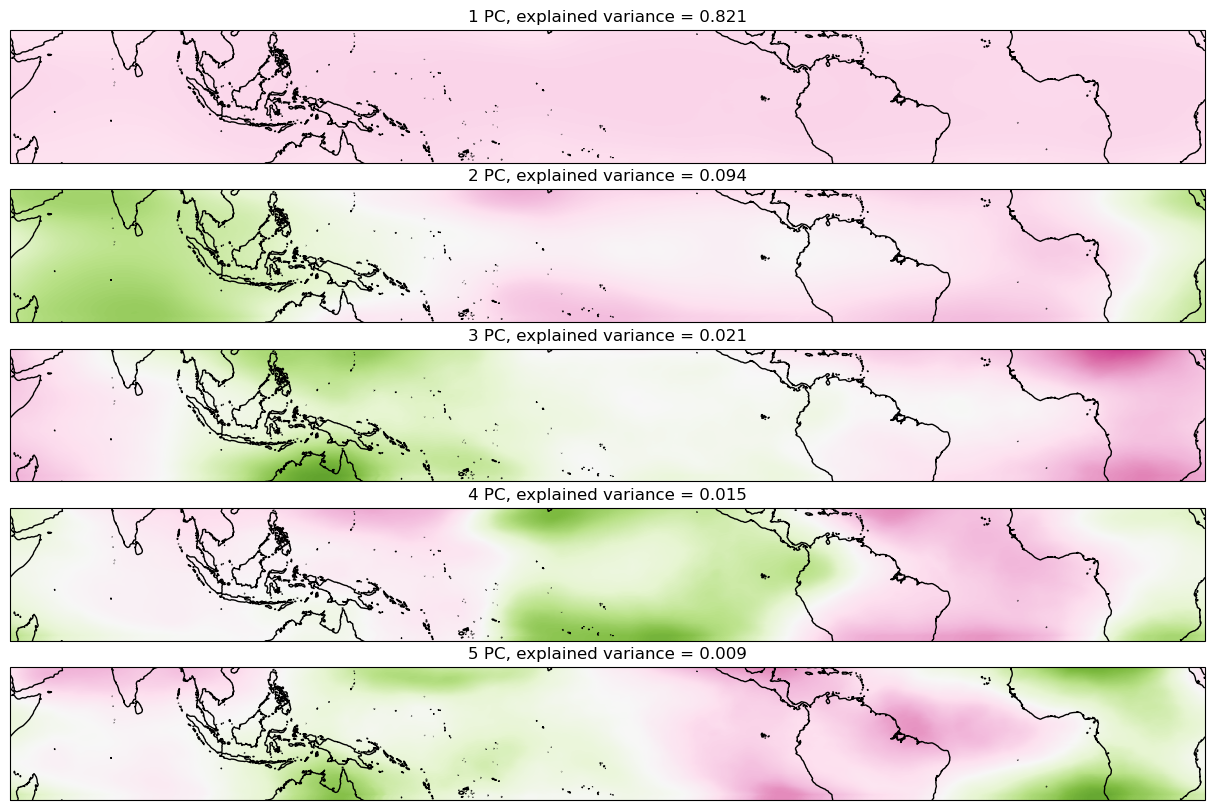

In [82]:
fig,xs = plt.subplots(len(era5_PCA.PCAs),1,figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

for i in range(len(era5_PCA.PCAs)) :
    ax=xs[i]
    ax.scatter(era5_tropics.longitude,era5_tropics.latitude,c=era5_ym_PCA.components.sel(PCAs=i+1),cmap='PiYG', vmin=-0.01, vmax=0.01)
    metcalc.set_regional_cartopy(ax)
    ax.set_title(f"{i+1} PC, explained variance = {era5_ym_PCA.sel(PCAs=i +1).explained_variance.values:.3f}")
    

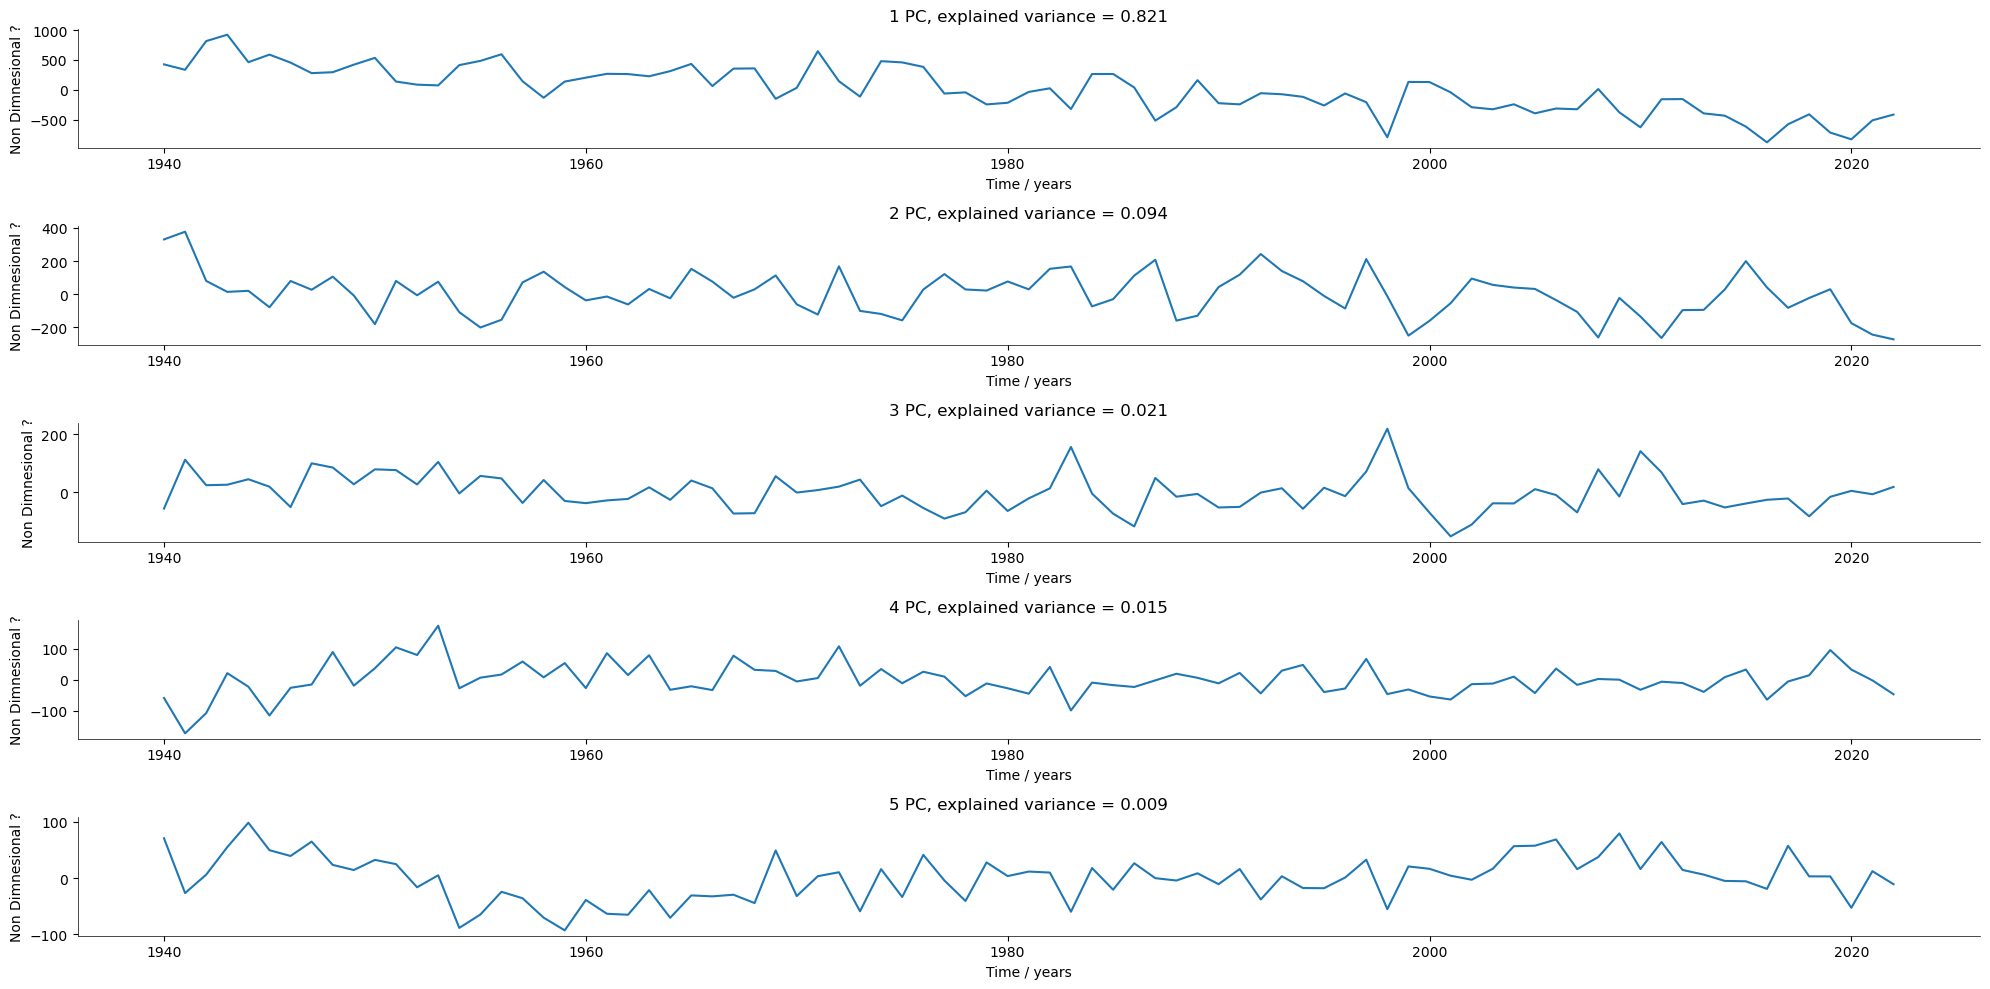

In [83]:
fig,xs = plt.subplots(len(era5_PCA.PCAs),1,figsize=(20,10))

for i in range(len(era5_PCA.PCAs)) :
    ax=xs[i]
    era5_ym_PCA.sel(PCAs=i +1).time_series.plot(x="time",ax=ax)
    ax.set_xlabel("Time / years")
    ax.set_ylabel("Non Dimnesional ?")
    ax.set_title(f"{i+1} PC, explained variance = {era5_ym_PCA.sel(PCAs=i +1).explained_variance.values:.3f}")
    metcalc.remove_axes(ax)
fig.tight_layout()
    

## ICA

ICA should not be used when data is guassian! This means we probably cant use it here

## Try with detrended data

In [72]:
def detrend(ds,an_dim="model_id") :
    ds_an_trend = ds.polyfit(dim="time", deg=1)
    ds_an = (ds["ta"] - ds.time * ds_an_trend["ta_polyfit_coefficients"].sel(degree=1)).to_dataset(name="ta")
    return ds_an

In [73]:
ssp585_jan_norm_dt = detrend(ssp585_jan_norm)

/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


In [74]:
ssp585_jan_norm_dt_PCA = PCA_wrapper(ssp585_jan_norm_dt, number_of_PCs = 5)
ssp585_jan_norm_dt_ICA = ICA_wrapper(ssp585_jan_norm_dt, number_of_PCs = 5)


/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-pac

In [75]:
example = ssp585_jan_norm_dt_PCA.isel(model_id=0)
example_ICA = ssp585_jan_norm_dt_ICA.isel(model_id=0)

## PCA

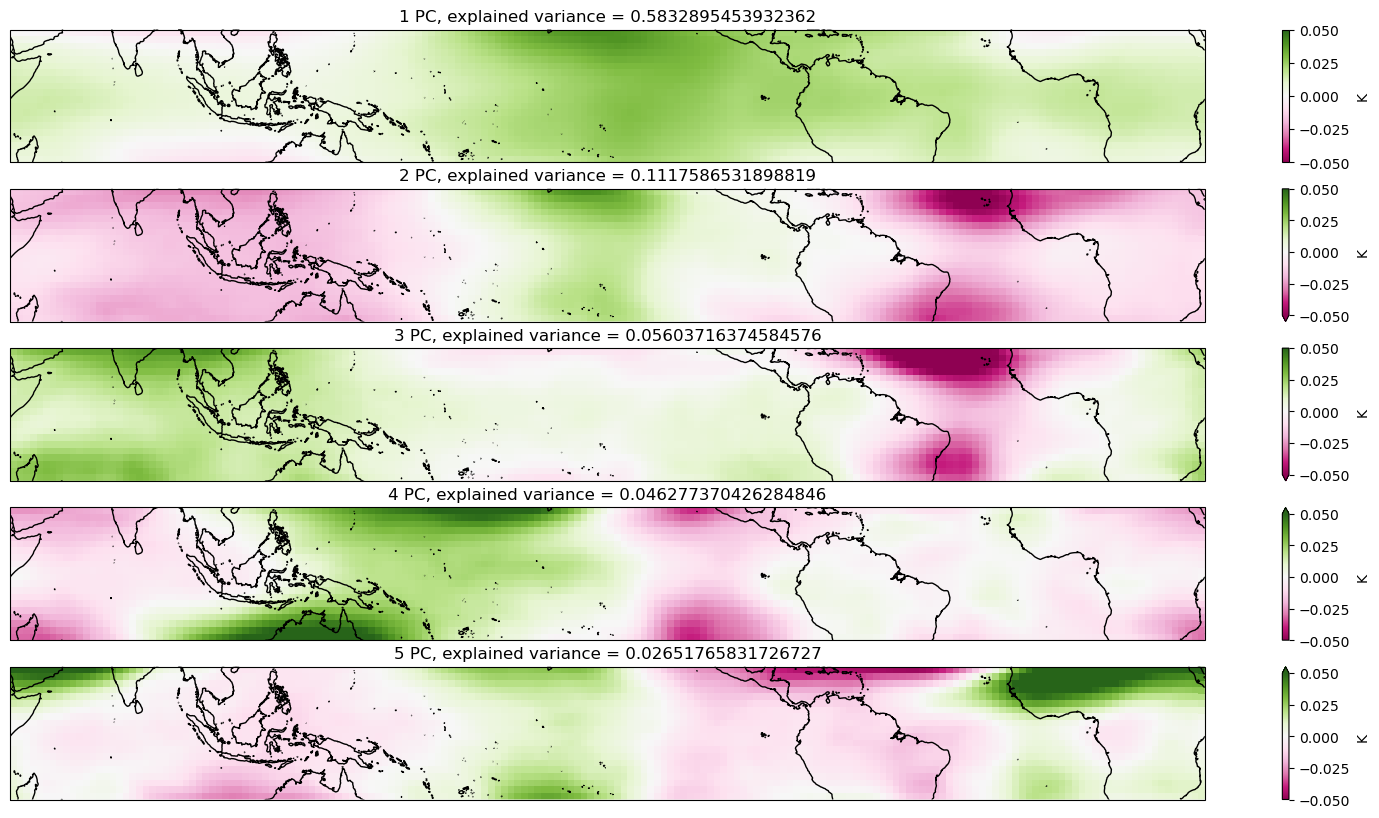

In [113]:
fig,xs = plt.subplots(len(example.PCAs),1,figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

for i in range(len(example.PCAs)) :
    ax=xs[i]
    example.sel(PCAs=i +1).components.plot(x="lon",y="lat",ax=ax,transform=ccrs.PlateCarree(),cmap='PiYG',cbar_kwargs={"label" : "K"}, vmin=-0.05, vmax=0.05)
    metcalc.set_regional_cartopy(ax)
    ax.set_title(f"{i+1} PC, explained variance = {example.sel(PCAs=i +1).explained_variance.values}")
    

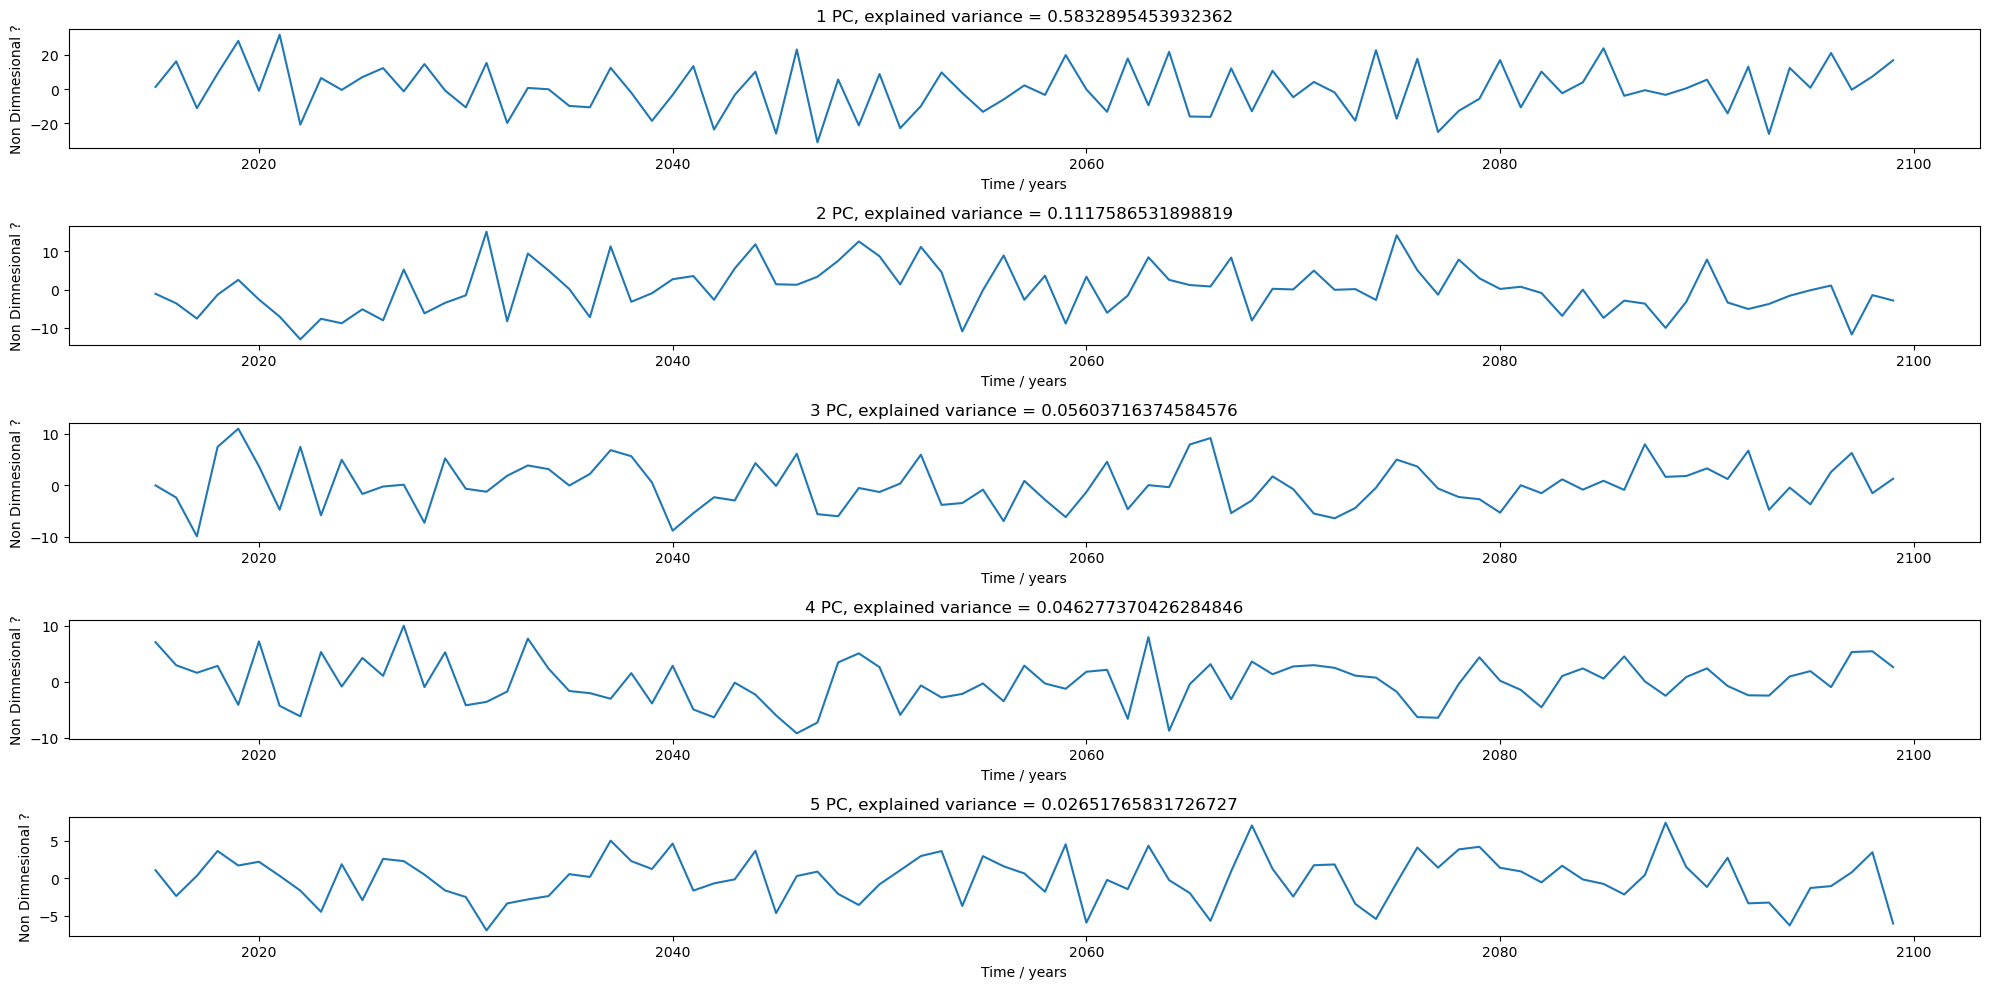

In [114]:
fig,xs = plt.subplots(len(example.PCAs),1,figsize=(20,10))

for i in range(len(example.PCAs)) :
    ax=xs[i]
    example.sel(PCAs=i +1).time_series.plot(x="time",ax=ax)
    ax.set_xlabel("Time / years")
    ax.set_ylabel("Non Dimnesional ?")
    ax.set_title(f"{i+1} PC, explained variance = {example.sel(PCAs=i +1).explained_variance.values}")
    
fig.tight_layout()
    

## ICA

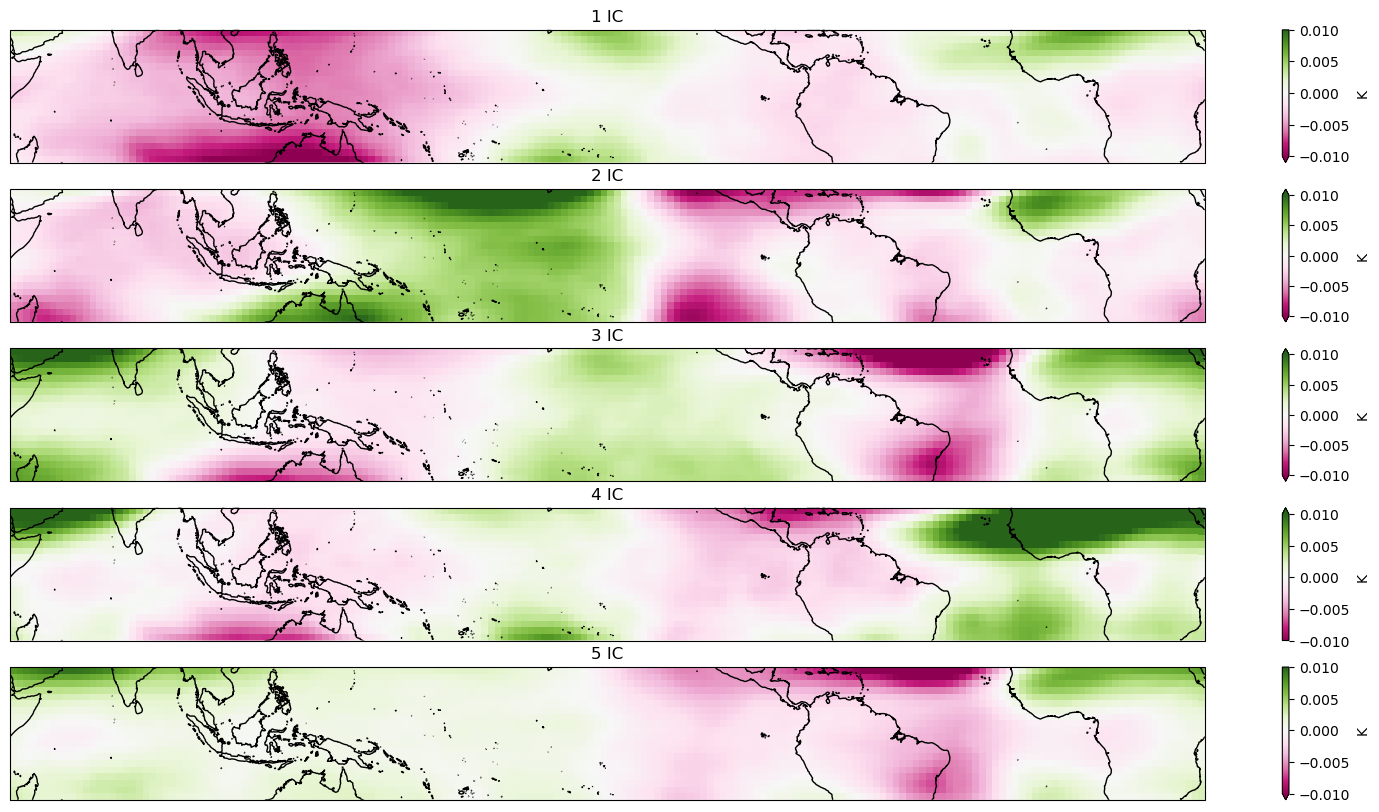

In [78]:
fig,xs = plt.subplots(len(example.PCAs),1,figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

for i in range(len(example.PCAs)) :
    ax=xs[i]
    example_ICA.sel(PCAs=i +1).components.plot(x="lon",y="lat",ax=ax,transform=ccrs.PlateCarree(),cmap='PiYG',cbar_kwargs={"label" : "K"}, vmin=-0.01, vmax=0.01)
    metcalc.set_regional_cartopy(ax)
    ax.set_title(f"{i+1} IC")
    

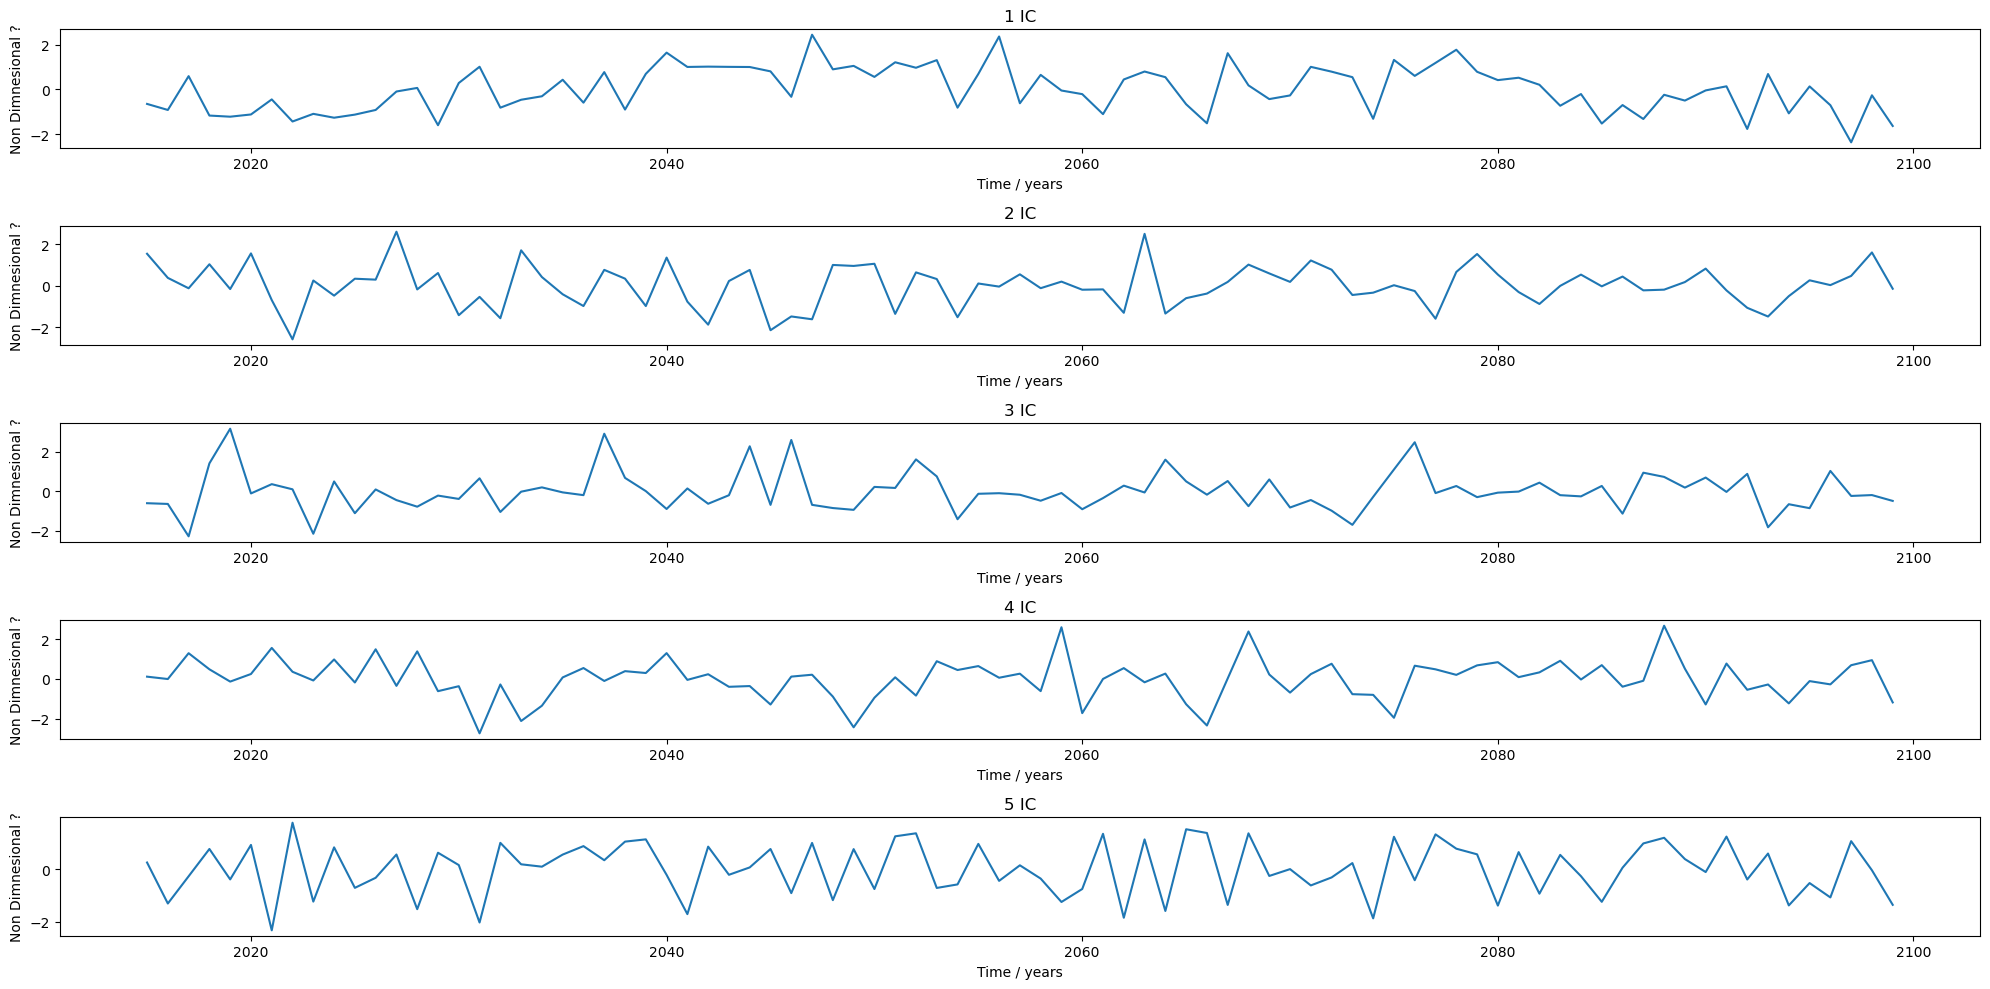

In [79]:
fig,xs = plt.subplots(len(example.PCAs),1,figsize=(20,10))

for i in range(len(example.PCAs)) :
    ax=xs[i]
    example_ICA.sel(PCAs=i +1).time_series.plot(x="time",ax=ax)
    ax.set_xlabel("Time / years")
    ax.set_ylabel("Non Dimnesional ?")
    ax.set_title(f"{i+1} IC")
    
fig.tight_layout()
    

In [8]:
!ls -l /work/ik1017/Catalogs

total 4778340
drwxrwxr-x  2 k204210 ik1017      12288 Apr 18  2023 archive
drwxr-sr-x. 3 k204210 ik1017       4096 Nov 22  2022 Candidates
-rwxrwxr-x  1 k204210 ik1017    1330797 Feb 27  2022 cmip6-retracted-outdated.csv.gz
-rwxrwxr-x  1 k204210 ik1017       1802 Apr 14  2022 cmip6-retracted-outdated.json
-rwxr-xr-x. 1 k204210 ik1017       6270 May 26  2023 dkrz_catalog.yaml
-rw-r--r--. 1 k204210 ik1017   49651280 Jun 17  2022 dkrz_cmip5_archive.csv.gz
-rwxrwxr-x  1 k204210 ik1017       2199 Jun 17  2022 dkrz_cmip5_archive.json
-rwxr-xr--. 1 k204210 ik1017   19976874 Apr 14  2023 dkrz_cmip5_disk.csv.gz
-rwxrwxr-x. 1 k204210 ik1017       2531 Jun 17  2022 dkrz_cmip5_disk.json
-rwxrwxr-x  1 k204210 ik1017   32141206 Aug  5  2021 dkrz_cmip5_disk_netcdf.csv.gz
-rwxrwxr-x  1 k204210 ik1017       2111 Apr 14  2022 dkrz_cmip5_disk_netcdf.json
-rwxrwxr-x  1 k204210 ik1017   39247019 Dec 13  2022 dkrz_cmip6_archive.csv.gz
-rw-r--r--  1 k204210 ik1017       6703 May  9  2022 dkrz_cmip6_cloud.csv

In [4]:
import intake
import intake_esm

In [1]:
!ls /pool/data/ERA5/E5/pl/an/1M/

060  075  076  129  130  131  132  133	135  138  155  157  203  246  247  248


temperature has 130

In [3]:
directory = "/pool/data/ERA5/E5/pl/an/1M/130"

https://docs.dkrz.de/doc/dataservices/finding_and_accessing_data/era_data/index.html

In [6]:
test = intake.open_esm_datastore(
    "/work/ik1017/Catalogs/dkrz_era5_disk.json")

/work/ka1176/paul/conda/ML_trop_temp/lib/python3.11/site-packages/intake_esm/cat.py:249: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [9]:
test.df.head()

project institution_id source_id era_id dataType   level_type frequency  \
0    era5          ecmwf       IFS     E1       an  model_level    hourly   
1    era5          ecmwf       IFS     E1       an  model_level    hourly   
2    era5          ecmwf       IFS     E1       an  model_level    hourly   
3    era5          ecmwf       IFS     E1       an  model_level    hourly   
4    era5          ecmwf       IFS     E1       an  model_level    hourly   

  stepType  table_id  code short_name                    long_name      units  \
0  instant       128    75       crwc  Specific rain water content  kg kg**-1   
1  instant       128    75       crwc  Specific rain water content  kg kg**-1   
2  instant       128    75       crwc  Specific rain water content  kg kg**-1   
3  instant       128    75       crwc  Specific rain water content  kg kg**-1   
4  instant       128    75       crwc  Specific rain water content  kg kg**-1   

  validation_date initialization_date  \
0      2000-01-01               False   
1      2000-01-02               False   
2      2000-01-03               False   
3      2000-01-04               False   
4      2000-01-05               False   

                                                 uri  \
0  /work/bk1099/data/E1/ml/an/1H/075/E1ml00_1H_20...   
1  /work/bk1099/data/E1/ml/an/1H/075/E1ml00_1H_20...   
2  /work/bk1099/data/E1/ml/an/1H/075/E1ml00_1H_20...   
3  /work/bk1099/data/E1/ml/an/1H/075/E1ml00_1H_20...   
4  /work/bk1099/data/E1/ml/an/1H/075/E1ml00_1H_20...   

                                                path format  
0  /work/bk1099/data/E1/ml/an/1H/075/E1ml00_1H_20...   grib  
1  /work/bk1099/data/E1/ml/an/1H/075/E1ml00_1H_20...   grib  
2  /work/bk1099/data/E1/ml/an/1H/075/E1ml00_1H_20...   grib  
3  /work/bk1099/data/E1/ml/an/1H/075/E1ml00_1H_20...   grib  
4  /work/bk1099/data/E1/ml/an/1H/075/E1ml00_1H_20...   grib

In [25]:
test.unique()

project                                                           [era5]
institution_id                                                   [ecmwf]
source_id                                                          [IFS]
era_id                                                      [E1, E5, ET]
dataType                                                        [an, fc]
level_type                        [model_level, pressure_level, surface]
frequency                                     [hourly, daily, invariant]
stepType                                      [instant, avg, max, accum]
table_id                                                      [128, 256]
code                   [75, 76, 77, 129, 130, 131, 132, 133, 135, 138...
short_name             [crwc, cswc, etadot, z, t, u, v, q, w, vo, lns...
long_name              [Specific rain water content, Specific snow wa...
units                  [kg kg**-1, s**-1, m**2 s**-2, K, m s**-1, Pa ...
validation_date        [2000-01-01, 2000-01-02, 200

In [32]:
query = dict(
    #era_id="E5",
    level_type="pressure_level",
    frequency="daily",
    #short_name="t"
)

In [33]:
test.search(**query)